In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

from tqdm import tqdm

In [2]:
df = pd.read_csv('Train.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Day-Month'] = df['Date'].dt.strftime('%m-%d')
df = df.sort_values(by='Date', ascending=True)

/var/folders/wc/g01grcxj65z_db1mfdrp2l140000gn/T/ipykernel_34357/2821824589.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
df.shape

(86584, 15)

In [4]:
# Drop columns ID and Date
# df = df.drop(['ID_Zindi', 'Date', 'ID'], axis=1)
df = df.drop(['ID_Zindi', "ID"], axis=1)
print(f"Size of DataFrame: {df.shape}")
df.head()

Size of DataFrame: (86584, 13)


,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,Day-Month
0,2019-01-01,45.601585,11.903551,0.0,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000,01-01
57,2019-01-01,45.396195,9.282700,0.0,NaN,0.471113,0.640860,0.000023,0.000200,NaN,14441.03373,41.375,01-01
56,2019-01-01,45.330361,9.414645,0.0,NaN,0.313861,0.671681,0.000023,0.000175,NaN,14443.24936,29.750,01-01
55,2019-01-01,45.306013,9.485263,0.0,NaN,0.454544,0.694752,0.000023,0.000291,NaN,14444.19946,33.350,01-01
54,2019-01-01,45.081987,9.700788,0.0,NaN,-0.203494,0.586172,0.000024,0.000368,0.000183,14444.03338,34.375,01-01


In [5]:
nan_counts = df.isna().sum()

# Print the number of NaN values alongside the column names
for column, count in nan_counts.items():
    print(f'Column: {column}, NaN Count: {count}')

Column: Date, NaN Count: 0
Column: LAT, NaN Count: 0
Column: LON, NaN Count: 0
Column: Precipitation, NaN Count: 0
Column: LST, NaN Count: 39786
Column: AAI, NaN Count: 12875
Column: CloudFraction, NaN Count: 12875
Column: NO2_strat, NaN Count: 12875
Column: NO2_total, NaN Count: 12875
Column: NO2_trop, NaN Count: 35473
Column: TropopausePressure, NaN Count: 12875
Column: GT_NO2, NaN Count: 4533
Column: Day-Month, NaN Count: 0


In [6]:
df = df.dropna(subset=['GT_NO2'])
df.shape

(82051, 13)

Day-Month
01-01    227
01-02    225
01-03    228
01-04    229
01-05    227
        ... 
12-27    231
12-28    227
12-29    225
12-30    229
12-31    230
Name: count, Length: 366, dtype: int64


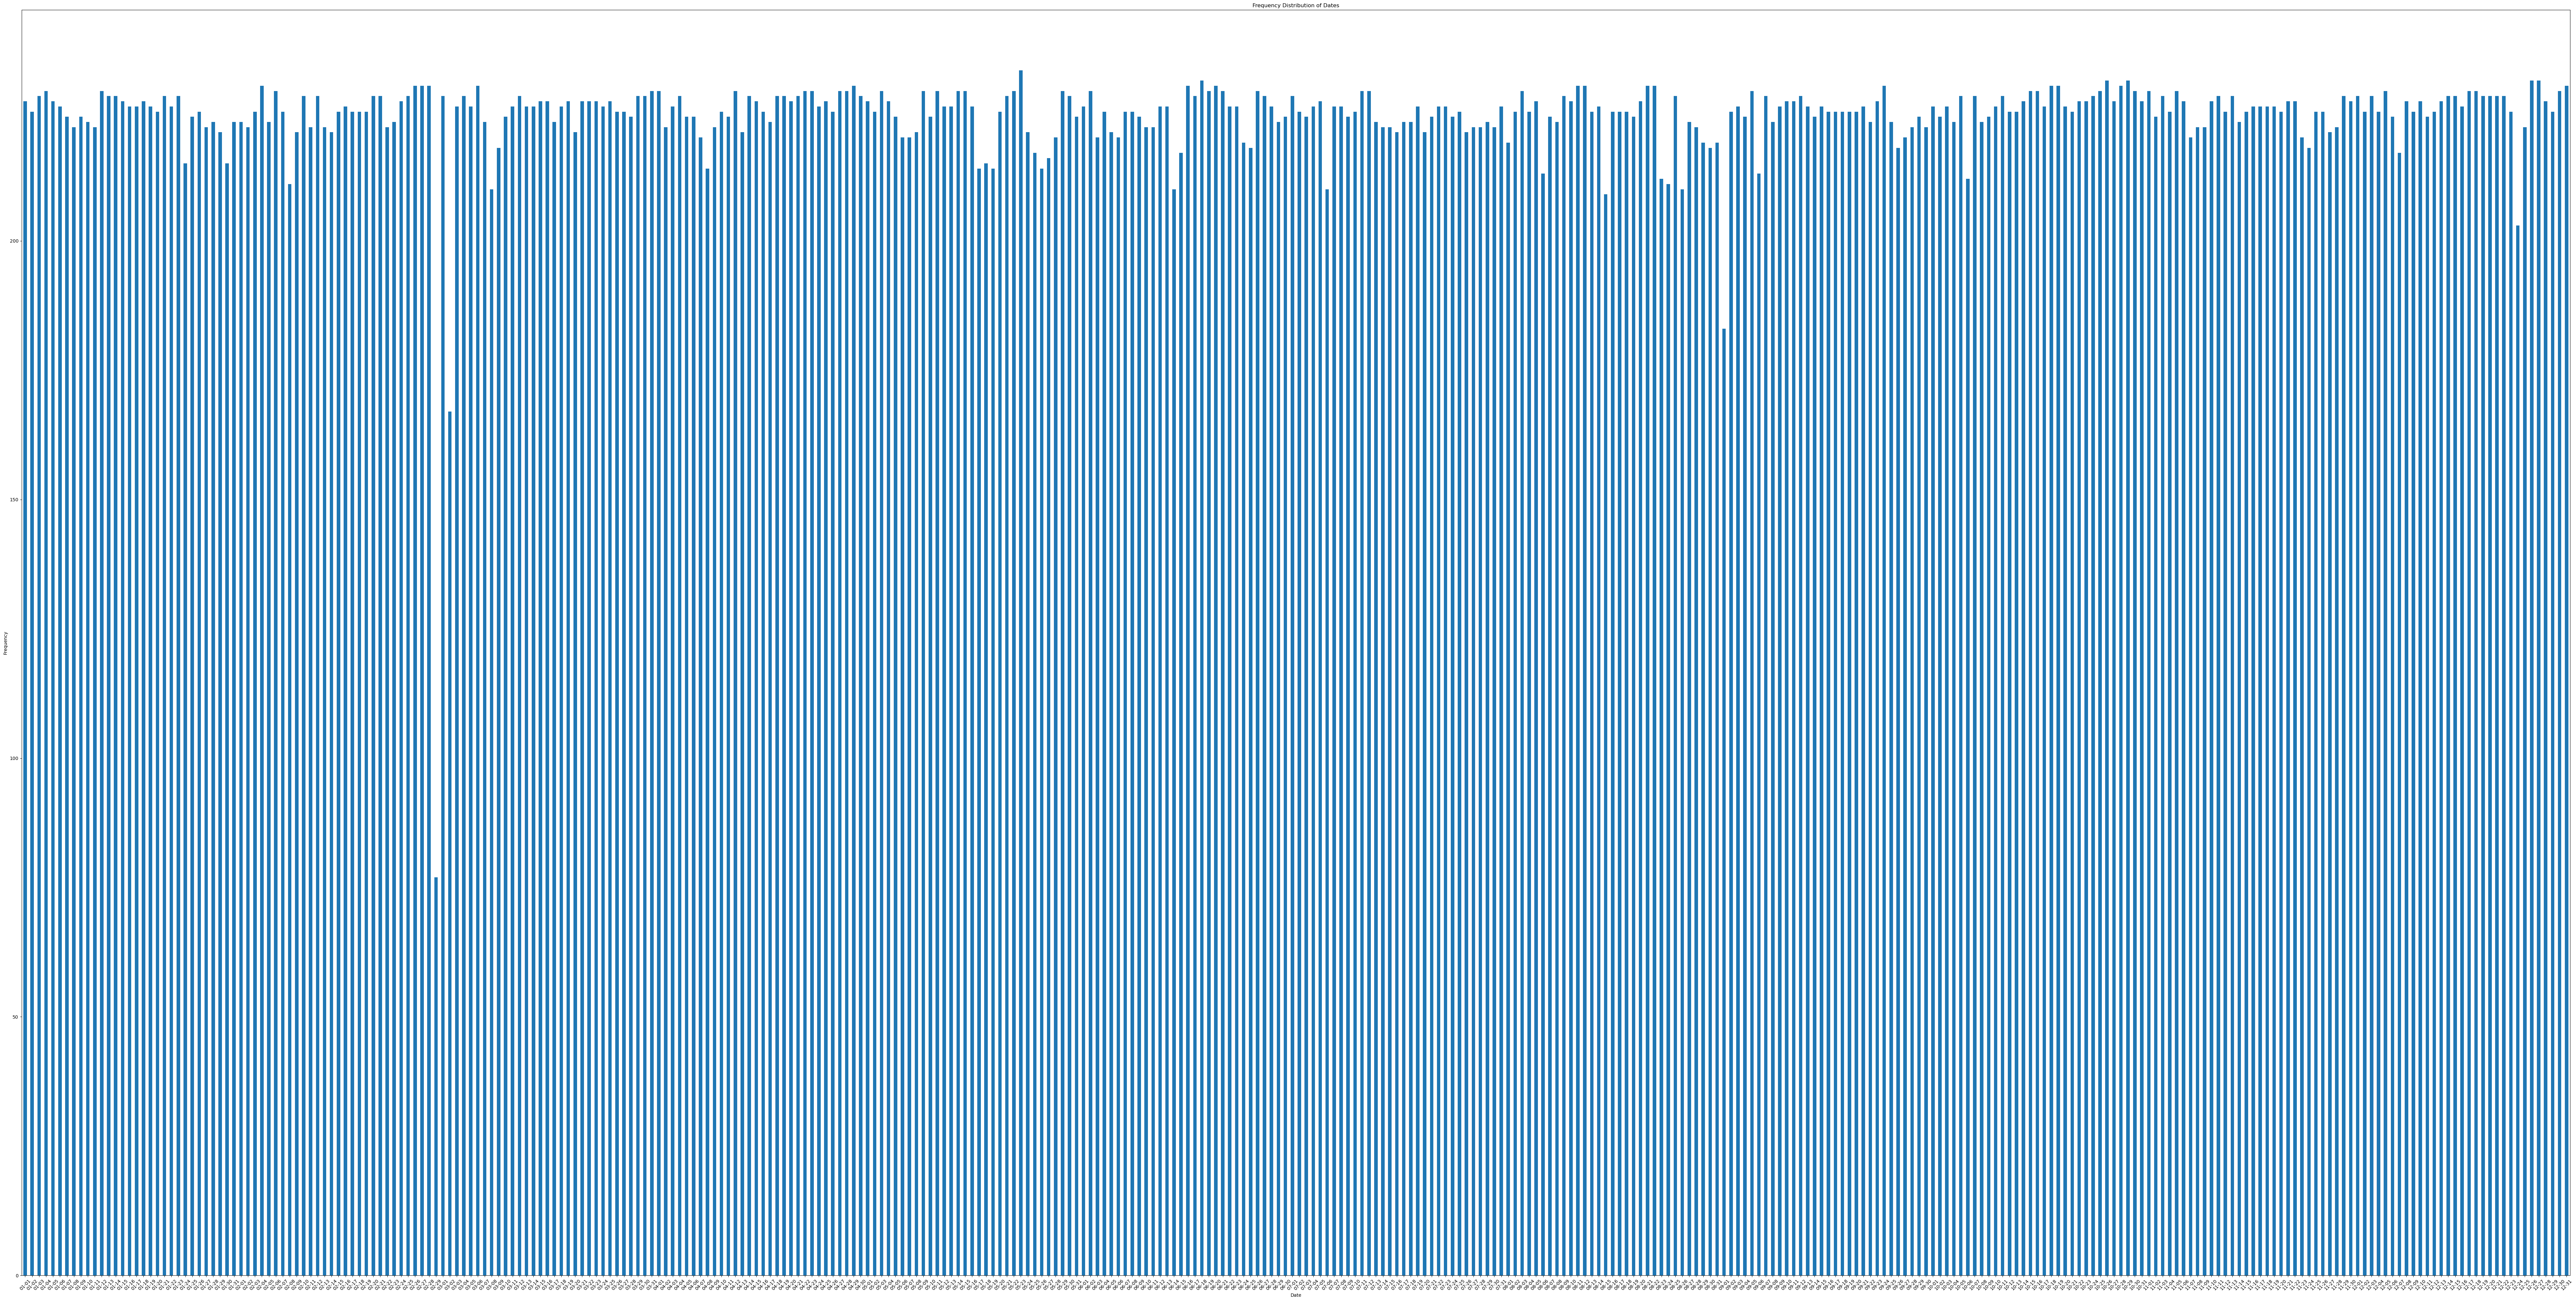

In [7]:
date_counts = df['Day-Month'].value_counts().sort_index()

print(date_counts)

# Plot the frequency distribution
plt.figure(figsize=(100, 50))
date_counts.plot(kind='bar')

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Dates')
plt.xticks(rotation=45)
plt.show()

### Perform KMeans Clustering Based on Location i.e LAT/LON

In [8]:
kmeans = KMeans(n_clusters=10, random_state=42)
df['Location_Cluster'] = kmeans.fit_predict(df[['LAT', 'LON']])

### Apply KNN Imputer for each Location Cluster

In [9]:
df.columns

Index(['Date', 'LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2',
       'Day-Month', 'Location_Cluster'],
      dtype='object')

In [10]:
# Initialize a list to store imputed DataFrames
imputed_dfs = []

# Group the DataFrame by clusters
clustered_groups = df.groupby('Location_Cluster')

for cluster, group in tqdm(clustered_groups):

    # Reset index for KNN Imputer
    group = group.reset_index(drop=True)
    
    # Prepare data for KNN Imputer
    imputer_data = group[['Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure',
       'Day-Month']].copy()
    
    # Convert 'Day-Month' to numerical format for KNN
    imputer_data['Day-Month'] = imputer_data['Day-Month'].apply(lambda x: int(x.replace('-', '')))
    
    # Apply KNN Imputer
    imputer = KNNImputer(n_neighbors=7)  # Adjust n_neighbors as needed
    imputed_values = imputer.fit_transform(imputer_data)
    
    # Replace the imputed columns back to the group DataFrame
    # Adjusting the slice to include all columns
    group[['Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure',
       'Day-Month']] = imputed_values  # Note: Ensure that the columns match in length
    
    # Append the imputed group DataFrame to the list
    imputed_dfs.append(group)

# Concatenate all the imputed DataFrames back together
df_imputed = pd.concat(imputed_dfs, axis=0).sort_index()

100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


In [14]:
df_imputed.head()
df_imputed.to_csv('Train_Data_Delete.csv', index=False)

# # Drop the 'Day-Month' column as it's no longer needed
df_clean = df_imputed.drop(columns=['Day-Month', 'Location_Cluster'])

df_clean.head()

,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,2019-01-01,45.330361,9.414645,0.000000,281.845714,0.313861,0.671681,0.000023,0.000175,0.000174,14443.24936,29.750
0,2019-01-01,45.716300,10.044766,0.000000,279.640000,-0.612119,0.089885,0.000023,0.000147,0.000170,14420.63506,19.175
0,2019-01-01,45.281956,8.988563,0.000000,281.222857,0.516055,0.704873,0.000023,0.000140,0.000120,14437.64238,31.175
0,2019-01-01,45.160568,10.795564,4.023135,288.842857,0.012465,0.880900,0.000024,0.000269,0.000106,14441.89312,27.650
0,2019-01-01,45.038758,11.790152,1.274564,305.742857,-0.176178,0.747464,0.000024,0.000116,0.000066,14438.79037,58.000


In [54]:
nan_counts = df_clean.isna().sum()

# Print the number of NaN values alongside the column names
for column, count in nan_counts.items():
    print(f'Column: {column}, NaN Count: {count}')

Column: Date, NaN Count: 0
Column: LAT, NaN Count: 0
Column: LON, NaN Count: 0
Column: Precipitation, NaN Count: 0
Column: LST, NaN Count: 0
Column: AAI, NaN Count: 0
Column: CloudFraction, NaN Count: 0
Column: NO2_strat, NaN Count: 0
Column: NO2_total, NaN Count: 0
Column: NO2_trop, NaN Count: 0
Column: TropopausePressure, NaN Count: 0
Column: GT_NO2, NaN Count: 0


Number of unique geographical locations with 1096 date values: 0


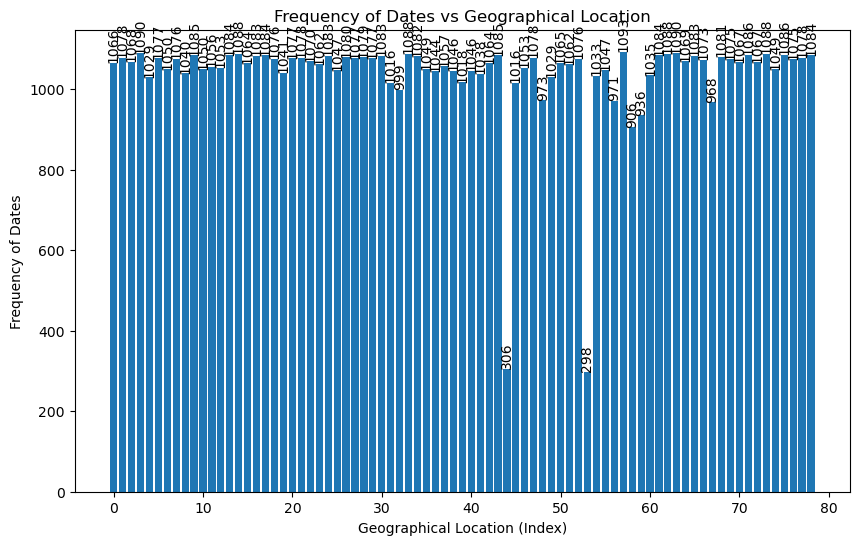

In [55]:
location_date_count = df.groupby(['LAT', 'LON'])['Date'].count().reset_index(name='DateCount')

locations_with_1096_dates = location_date_count[location_date_count['DateCount'] >= 1096]

# Count the number of unique geographical locations with 1096 date values
number_of_locations_with_1096_dates = locations_with_1096_dates.shape[0]

print(f"Number of unique geographical locations with 1096 date values: {number_of_locations_with_1096_dates}")

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(range(location_date_count.shape[0]), location_date_count['DateCount'])
plt.xlabel('Geographical Location (Index)')
plt.ylabel('Frequency of Dates')
plt.title('Frequency of Dates vs Geographical Location')

# Adding the exact frequency value on top of each bar, oriented vertically
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', rotation=90)

plt.show()

In [35]:
df_clean.to_csv('Train_Cleaned_KNN.csv', index=False)

In [15]:
df_clean['Location'] = df_clean['LAT'].astype(str) + ", " + df_clean['LON'].astype(str)

# Count the number of occurrences of each date for each location
location_date_counts = df_clean.groupby('Location')['Date'].nunique().reset_index()

# Rename columns for clarity
location_date_counts.columns = ['Location', 'Date_Frequency']

min_value = location_date_counts['Date_Frequency'].min()

# Find the maximum value in 'Date_Frequency'
max_value = location_date_counts['Date_Frequency'].max()

# Find the location with the least frequency
least_frequent_location = location_date_counts.loc[location_date_counts['Date_Frequency'].idxmin()]

# Find the location with the highest frequency
most_frequent_location = location_date_counts.loc[location_date_counts['Date_Frequency'].idxmax()]

print(f"Minimum Date Frequency: {min_value}")
print(f"Maximum Date Frequency: {max_value}")
print(f"Location with Least Frequency: {least_frequent_location}")
print(f"Location with Most Frequency: {most_frequent_location}")

Minimum Date Frequency: 298
Maximum Date Frequency: 1093
Location with Least Frequency: Location          45.54264789, 10.21120522
Date_Frequency                         298
Name: 53, dtype: object
Location with Most Frequency: Location          45.55956112, 11.53865377
Date_Frequency                        1093
Name: 57, dtype: object


In [56]:
filtered_locations = location_date_counts[(location_date_counts['Date_Frequency'] >= 800)]

# Print the filtered locations and their frequencies
print("Locations with Date_Frequency between 800 and 900:")
print(filtered_locations[['Location', 'Date_Frequency']])

Locations with Date_Frequency between 800 and 900:
                    Location  Date_Frequency
0   44.92469405, 10.51750207            1066
1   44.99954599, 9.008437382            1078
2   45.01687782, 11.07609463            1068
3   45.03875842, 11.79015164            1090
4   45.04007657, 8.914144599            1029
..                       ...             ...
74    45.71629992, 10.044766            1049
75  45.73083672, 9.125734327            1086
76  45.75927327, 11.73585212            1075
77  45.84220726, 9.351658166            1078
78  45.88973369, 12.30712448            1084

[77 rows x 2 columns]


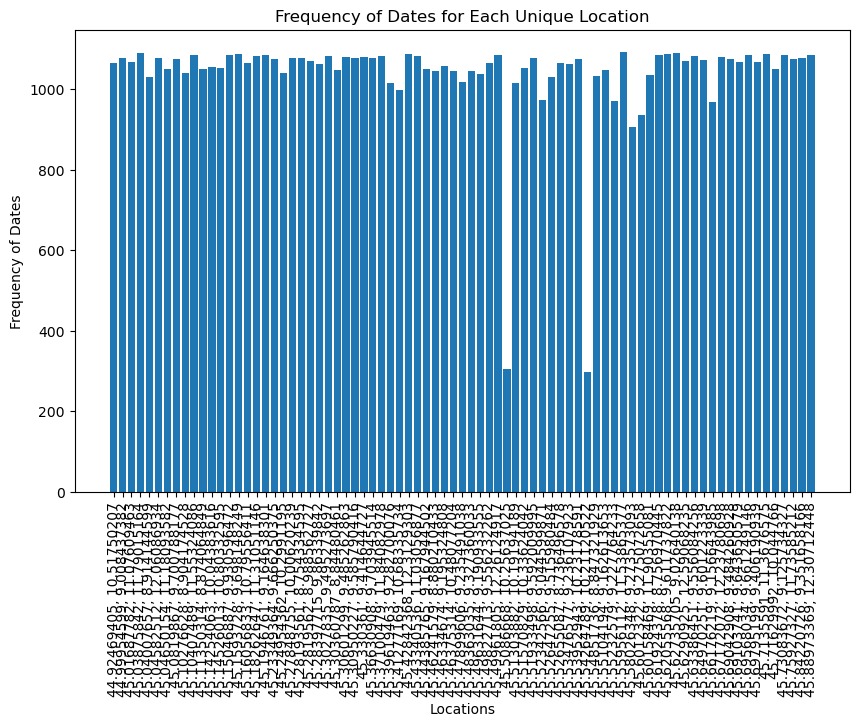

In [57]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the data
plt.bar(location_date_counts['Location'], location_date_counts['Date_Frequency'])

# Customize the plot
plt.xlabel('Locations')
plt.ylabel('Frequency of Dates')
plt.title('Frequency of Dates for Each Unique Location')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability

# Display the plot
plt.show()

In [59]:
df_clean['Location'] = df_clean['LAT'].astype(str) + ", " + df_clean['LON'].astype(str)

# Group by location and filter out those with fewer than 900 rows
location_counts = df_clean.groupby('Location').size()
valid_locations = location_counts[location_counts >= 900].index

filtered_df = df_clean[df_clean['Location'].isin(valid_locations)]

In [62]:
filtered_df = filtered_df.drop(columns=['Location'])

In [63]:
nan_counts = filtered_df.isna().sum()

# Print the number of NaN values alongside the column names
for column, count in nan_counts.items():
    print(f'Column: {column}, NaN Count: {count}')

Column: Date, NaN Count: 0
Column: LAT, NaN Count: 0
Column: LON, NaN Count: 0
Column: Precipitation, NaN Count: 0
Column: LST, NaN Count: 0
Column: AAI, NaN Count: 0
Column: CloudFraction, NaN Count: 0
Column: NO2_strat, NaN Count: 0
Column: NO2_total, NaN Count: 0
Column: NO2_trop, NaN Count: 0
Column: TropopausePressure, NaN Count: 0
Column: GT_NO2, NaN Count: 0


In [64]:
filtered_df.to_csv('Train_Cleaned_KNN_Filtered.csv', index=False)

### ADF Test

In [2]:
from statsmodels.tsa.stattools import adfuller

# Dictionary to store ADF test results for each location
adf_results = {}

# Perform ADF test for each geographical location
for (lat, lon), group in grouped:
    # Sort by Date to ensure time order
    group_sorted = group.sort_values('Date')

    # Extract the 'Ground Truth NO2' time series
    no2_series = group_sorted['GT_NO2']

    # Perform ADF test
    adf_test_result = adfuller(no2_series.dropna())  # Drop NaNs if present

    # Store results
    adf_results[(lat, lon)] = {
        'ADF Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        'Critical Values': adf_test_result[4],
        'Number of Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3]
    }

In [3]:
filtered_df = pd.read_csv('Train_Cleaned_KNN_Filtered.csv')

In [4]:
grouped = filtered_df.groupby(['LAT', 'LON'])

In [17]:
for (lat, lon), group in grouped:
    print(lat, lon, group.shape)
    print(group.head(10))
    break

44.92469405 10.51750207 (1066, 12)
           Date        LAT        LON  Precipitation         LST       AAI  \
26   2019-01-01  44.924694  10.517502       0.000000  292.402857  0.286079   
62   2019-01-02  44.924694  10.517502       8.211939  301.414286 -0.579522   
123  2019-01-03  44.924694  10.517502       0.000000  307.257143 -0.886214   
181  2019-01-04  44.924694  10.517502       0.000000  294.240000 -0.894068   
212  2019-01-05  44.924694  10.517502       0.000000  303.260000 -0.987795   
284  2019-01-06  44.924694  10.517502       0.000000  305.520000 -1.123626   
328  2019-01-07  44.924694  10.517502       0.000000  308.280000 -1.486456   
355  2019-01-08  44.924694  10.517502       0.000000  305.820000 -1.519680   
408  2019-01-09  44.924694  10.517502       0.000000  309.720000 -1.879356   
446  2019-01-10  44.924694  10.517502       0.000000  298.460000 -1.289062   

     CloudFraction  NO2_strat  NO2_total  NO2_trop  TropopausePressure  GT_NO2  
26        0.954099   0.00

##### Original Series

In [18]:
# Dictionary to store ADF test results for each location
adf_results = {}

# Perform ADF test for each geographical location
for (lat, lon), group in grouped:
    # Sort by Date to ensure time order
    group_sorted = group.sort_values('Date')

    # Extract the 'Ground Truth NO2' time series
    no2_series = group_sorted['GT_NO2']

    # Perform ADF test
    adf_test_result = adfuller(no2_series.dropna())  # Drop NaNs if present

    # Store results
    adf_results[(lat, lon)] = {
        'ADF Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        'Critical Values': adf_test_result[4],
        'Number of Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3]
    }

In [19]:
for k, v in adf_results.items():
    print(f"Location: {k}, ADF Statistic: {v['ADF Statistic']}, p-value: {v['p-value']}, Number of Lags Used: {v['Number of Lags Used']}, Critical Values: {v['Critical Values']}")

Location: (44.92469405, 10.51750207), ADF Statistic: -4.1336058821249715, p-value: 0.0008517962956873031, Number of Lags Used: 21, Critical Values: {'1%': -3.43662916802936, '5%': -2.864312406409634, '10%': -2.5682461404339336}
Location: (44.99954599, 9.008437382), ADF Statistic: -4.1660435487116585, p-value: 0.000751746946505585, Number of Lags Used: 21, Critical Values: {'1%': -3.436557639266102, '5%': -2.8642808573632874, '10%': -2.5682293371570823}
Location: (45.01687782, 11.07609463), ADF Statistic: -6.552472163680821, p-value: 8.781021411436665e-09, Number of Lags Used: 8, Critical Values: {'1%': -3.436540010983293, '5%': -2.8642730819775406, '10%': -2.5682251959417948}
Location: (45.03875842, 11.79015164), ADF Statistic: -4.410956867670534, p-value: 0.00028385609387872215, Number of Lags Used: 21, Critical Values: {'1%': -3.436487721786906, '5%': -2.8642500182800266, '10%': -2.568212912125293}
Location: (45.04007657, 8.914144599), ADF Statistic: -3.9270343235454135, p-value: 0.0

##### First Order Difference

In [20]:
grouped = filtered_df.groupby(['LAT', 'LON'])

In [26]:
differenced_results = {}
adf_results = {}

for (lat, lon), group in grouped:
    group_sorted = group.sort_values('Date')
    group_sorted['NO2_Diff'] = group_sorted['GT_NO2'].diff()

    # # Store the differenced sequence
    no2_diff_series = group_sorted['NO2_Diff'].dropna() 
    
    # Perform ADF test on the differenced series
    adf_test_result = adfuller(no2_diff_series)

    # Store ADF test results
    adf_results[(lat, lon)] = {
        'ADF Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        'Critical Values': adf_test_result[4],
        'Number of Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3]
    }

In [27]:
for k, v in adf_results.items():
    print(f"Location: {k}, ADF Statistic: {v['ADF Statistic']}, p-value: {v['p-value']}, Number of Lags Used: {v['Number of Lags Used']}, Critical Values: {v['Critical Values']}")

Location: (44.92469405, 10.51750207), ADF Statistic: -10.541730600203898, p-value: 8.615221147668115e-19, Number of Lags Used: 22, Critical Values: {'1%': -3.43664125006105, '5%': -2.864317735333004, '10%': -2.5682489786730818}
Location: (44.99954599, 9.008437382), ADF Statistic: -10.747246701307889, p-value: 2.721886181546607e-19, Number of Lags Used: 20, Critical Values: {'1%': -3.436557639266102, '5%': -2.8642808573632874, '10%': -2.5682293371570823}
Location: (45.01687782, 11.07609463), ADF Statistic: -10.935769703167292, p-value: 9.568886920932455e-20, Number of Lags Used: 20, Critical Values: {'1%': -3.436617132314828, '5%': -2.864307097893787, '10%': -2.568243313067353}
Location: (45.03875842, 11.79015164), ADF Statistic: -13.20166244278421, p-value: 1.0913224692804482e-24, Number of Lags Used: 18, Critical Values: {'1%': -3.4364762217105844, '5%': -2.8642449457774135, '10%': -2.5682102104987337}
Location: (45.04007657, 8.914144599), ADF Statistic: -13.130826080619206, p-value: 

##### Second Order Difference

In [2]:
grouped = filtered_df.groupby(['LAT', 'LON'])

NameError: name 'filtered_df' is not defined

In [29]:
second_order_differenced_results = {}
adf_results = {}

for (lat, lon), group in grouped:
    # Sort by Date to ensure time order
    group_sorted = group.sort_values('Date')
    group_sorted['NO2_Diff_1'] = group_sorted['GT_NO2'].diff()
    group_sorted['NO2_Diff_2'] = group_sorted['NO2_Diff_1'].diff()
    
    # Extract the second-order differenced series for ADF test
    no2_diff_2_series = group_sorted['NO2_Diff_2'].dropna()  # Drop NaNs if present after differencing
    
    # Perform ADF test on the second-order differenced series
    adf_test_result = adfuller(no2_diff_2_series)

    # Store ADF test results
    adf_results[(lat, lon)] = {
        'ADF Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        'Critical Values': adf_test_result[4],
        'Number of Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3]
    }

In [30]:
for k, v in adf_results.items():
    print(f"Location: {k}, ADF Statistic: {v['ADF Statistic']}, p-value: {v['p-value']}, Number of Lags Used: {v['Number of Lags Used']}, Critical Values: {v['Critical Values']}")

Location: (44.92469405, 10.51750207), ADF Statistic: -16.04872917795157, p-value: 5.806085371226745e-29, Number of Lags Used: 20, Critical Values: {'1%': -3.436635203238866, '5%': -2.8643150683130307, '10%': -2.568247558190521}
Location: (44.99954599, 9.008437382), ADF Statistic: -15.710490341624931, p-value: 1.3613854267632338e-28, Number of Lags Used: 20, Critical Values: {'1%': -3.4365635376940706, '5%': -2.86428345899922, '10%': -2.5682307228049686}
Location: (45.01687782, 11.07609463), ADF Statistic: -15.49299685642209, p-value: 2.4709718491296725e-28, Number of Lags Used: 20, Critical Values: {'1%': -3.4366231443991118, '5%': -2.864309749608104, '10%': -2.568244725395481}
Location: (45.03875842, 11.79015164), ADF Statistic: -15.175011879435445, p-value: 6.312771308078493e-28, Number of Lags Used: 22, Critical Values: {'1%': -3.4365050530846846, '5%': -2.864257662806096, '10%': -2.568216983623179}
Location: (45.04007657, 8.914144599), ADF Statistic: -14.419043513799503, p-value: 7